# Cell type annotation of FICTURE output

* creating and export multiple plots across all available ficture approaches (different number of preset factors nF5 to nF50, as well as annotated RNA-seq input from ABCAtlas)
* set up for MERFISH sample foxf2_s2_r1

In [1]:
import json
import os
from datetime import date

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import spatialdata as sd
from scipy.stats import zscore

/dss/dsshome1/0C/ra98gaq/miniconda3/envs/sdata/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


In [2]:
import sys

sys.path.append("/home")
import src.ficture_plot as ficture_plot

In [3]:
data_dir = os.path.abspath("/home/data")
!ls -l $data_dir

lrwxrwxrwx 1 ra98gaq pn52ra 53 Mar 12 17:01 /home/data -> /dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark


In [4]:
cohort_name = "foxf2"
slide_name = "s2"
region_name = "r1"
sample_name = f"{cohort_name}_{slide_name}_{region_name}"
sdata_file = os.path.join(
    data_dir, "samples", sample_name, "results", "Ficture", "sdata.zarr"
)
sample_name

'foxf2_s2_r1'

In [5]:
ficture_output = os.listdir(
    os.path.join(data_dir, "samples", sample_name, "results", "Ficture", "output")
)
ficture_output
# nF21.d_6 based on pseudobulk RNA-seq input (excl MBP)
# nF28.d_6 based on pseudobulk RNA-seq input (excl MBP and incl vascular subtypes such as EC zonation)

['nF50.d_6',
 'nF28.d_6-bulkRNAseq-inclzonation',
 'nF10.d_6',
 'nF30.d_6',
 'nF5.d_6',
 'nF25.d_6',
 'nF21.d_6-bulkRNAseq-exclMBP',
 'nF20.d_6']

In [6]:
all_factors = [f.split(".d_6")[0] for f in ficture_output]
all_factors

['nF50', 'nF28', 'nF10', 'nF30', 'nF5', 'nF25', 'nF21', 'nF20']

In [7]:
i = 7
factor_i = all_factors[i]
factor_i_raw_name = ficture_output[i]
factor_no = int(factor_i.split("nF")[1])
factor_i, factor_no

('nF20', 20)

In [8]:
base_dir = os.path.join(
    data_dir,
    "samples",
    sample_name,
    "results",
    "Ficture",
    "analysis",
    "factor_annotation",
    factor_i,
)
os.makedirs(base_dir, exist_ok=True)

In [ ]:
if "sdata" not in globals():
    sdata = sd.read_zarr(sdata_file)

In [ ]:
sdata

In [ ]:
sdata[f"{sample_name}_all_transcript_factors"].head(2)

In [ ]:
sdata[f"{sample_name}_transcripts"].head(2)

In [ ]:
assert (
    len(
        sdata[f"{sample_name}_all_transcript_factors"][f"{factor_i}_factors"]
        .compute()
        .unique()
    )
    - 1  # -1 for additional factor of unassigned transcripts
    == factor_no
)

Note:
- nF28.d_6-bulkRNAseq-inclzonation does not contain factors 18 and 20, because these input cell types were not detected

## Marker genes

In [68]:
# from Allen mouse brain scRNA-seq atlas (Yao 2023 Nature, 4M cells)
# computed using edgeR of pseudobulks, using author-derived cell annotations (see separate script)
ABCAtlas_marker_df = pd.read_csv(
    os.path.join(
        data_dir,
        "misc",
        "scRNAseq_ref_ABCAtlas_Yao2023Nature",
        "marker_genes",
        "20250211_cell_type_markers_top100.csv",
    )
)
# select top 50 markers for each type
ABCAtlas_marker_df = ABCAtlas_marker_df.head(50)
ABCAtlas_marker = ABCAtlas_marker_df.to_dict(orient="list")
ABCAtlas_marker_df.head(2)

,BAMs,Ependymal,SMCs,Pericytes,Microglia,VLMCs,ECs,Immune-Other,ABCs,OECs,...,Oligodendrocytes,Neurons-Dopa,Astrocytes,Neurons-Immature,Bergmann,Neurons-Other,Neurons-Dopa-Gaba,Neurons-Gaba,Neurons-Glyc-Gaba,Neurons-Glut
0,Pf4,Ttr,Acta2,Higd1b,Siglech,Igf2,Ly6c1,Lyz2,Mgp,Fabp7,...,Fa2h,Dlk1,Atp13a4,Dlx6os1,Gpr37l1,Slc18a2,Dlk1,Pvalb,Pvalb,Slc17a6
1,Cd163,Ccdc153,Myh11,Abcc9,Mir142hg,Dcn,Slco1a4,Mir142hg,Col1a1,Npy,...,Opalin,Vip,Gm12239,Gm38505,Slc1a3,Ddc,Chrm2,Dlx6os1,Slc32a1,Nrg3os


In [69]:
ABCAtlas_marker_df.shape

(50, 21)

In [70]:
marker_dicts = {}
marker_dicts["ABCAtlas_marker"] = ABCAtlas_marker

In [71]:
# load markers from manual selection (literature review) for 500 plex mouse brain gene panel 2024
marker_path = os.path.join(data_dir, "misc", "marker_genes_manual")
files = [
    "merfish_cell_supertypes.json",  # merfish_cell_supertypes / also contain cell(sub)-type specific genes
    "merfish_cell_types.json",  # cell types from gene panel / also contain sub-type specific genes
    "merfish_EC_subtypes.json",  # EC cell subtypes from gene panel
    "merfish_vascular_subtypes_nonEC.json",  # PC/SMC/Fibroblast/Ependymal cell subtypes from gene panel
]
for file in files:
    with open(os.path.join(marker_path, file), "r") as f:
        marker_dicts[file.split(".")[0]] = json.load(f)

In [73]:
list(marker_dicts.keys())

['ABCAtlas_marker',
 'merfish_cell_supertypes',
 'merfish_cell_types',
 'merfish_EC_subtypes',
 'merfish_vascular_subtypes_nonEC']

## FICTURE DE genes
Compare overlap of marker genes and top factor genes computed by FICTURE  
Note: FICTURE only reports 5-10 top hits

In [22]:
ficture_DEGs_file = os.path.join(
    data_dir,
    "samples",
    sample_name,
    "results",
    "Ficture",
    "output",
    factor_i_raw_name,
    f"{factor_i}.d_6.prj_6.r_4_5.factor.info.tsv",
)

In [23]:
ficture_DEGs = pd.read_table(ficture_DEGs_file)
ficture_DEGs = ficture_DEGs.set_index("Factor").sort_index()
ficture_DEGs.head(2)

,RGB,Weight,PostUMI,TopGene_pval,TopGene_fc,TopGene_weight
Factor,,,,,,
0,"242,200,58",0.16002,15464018,"Mbp, Gfap, Lpar1, S100b, Serpina3n, Gatm, Wnt2...","Mbp, Lpar1, Gfap, Serpina3n, S100b, Wnt2b, Gat...","Mbp, Gfap, S100b, Gatm, Lpar1, Apoe, Serpina3n..."
1,"253,169,50",0.08348,8067551,"Meg3, Aldh1a2, Fnbp4, Col4a2, Slc38a5, Slc11a2...","Meg3, Slc38a5, Aldh1a2, Slc22a2, Fxyd5, Cfp, T...","Meg3, Dnm1, Lrp1, Fnbp4, Kansl1, Col4a2, Ncam1..."


### List

In [24]:
# Limit to the first 15 genes per factor
ficture_DEGs["TopGene_fc_manual"] = ficture_DEGs["TopGene_fc"].apply(
    lambda x: ", ".join(x.split(", ")[:15])
)
pd.set_option("display.max_colwidth", None)
top_degs_table = ficture_DEGs[["TopGene_fc_manual"]].rename(
    columns={"TopGene_fc_manual": "Top DEGs"}
)
top_degs_table

,Top DEGs
Factor,
0,"Mbp, Lpar1, Gfap, Serpina3n, S100b, Wnt2b, Gatm, Acer2, Ccl3"
1,"Meg3, Slc38a5, Aldh1a2, Slc22a2, Fxyd5, Cfp, Tjp3, Nid2, Nkg7, Depp1, Col4a2, Fbn1, Slc11a2, Cd3e, Fnbp4"
2,"Cldn11, Hapln2, Mag, Opalin, Trf, Cnp, Sox10, Enpp2, Plxnb3, Apod, Il33, Enpp6, Adamtsl4, Gatm, Tgfbi"
3,"Dnm1, Rab6a, Slc4a10, Rad54b, Acsl4, Dpp4, Gjb2, Cnn1, Itgax, Eno2, Fgfbp1, Rell1, Cltc, Nmt1, Cd163"
4,"Hs3st2, Slc17a7, Fezf2, Tbr1, Pde1a, Hs3st4, Fgf5, Prss23, Prkcg, Ccnd1, Eln, Nfkb2, Pdgfb, Scube1, Ccn2"
5,"Gja1, Plpp3, Mfge8, Htra1, Sox9, Aqp4, C4b, Prdm16, Vcam1, Notch2, Vegfa, Slc7a11, Notch1, Wnt7a, Ptprz1"
6,"Matn2, Slc7a14, Slc26a10, Itga8, Cxcl12, Cemip, Itga11, Prox1, Dcakd, Runx2, Arl15, Pxdn, Itga7, Serpina3n, Nmt1"
7,"Cldn5, Vtn, Flt1, Slco1a4, Ly6c1, Rgs5, Klf4, Abcc9, Tie1, Igf2, Foxf2, Abcb1a, Pecam1, Nos3, Eng"
8,"Lamp5, A830036E02Rik, Lamc2, Crhr1, Cux2, Krt12, Rspo1, AI593442, Cdh6, Gm12371, Lama4, Fbln2, Susd5, Scube1, Pttg1"


In [26]:
pd.reset_option("display.max_colwidth")
# export
top_degs_table.to_csv(
    os.path.join(
        base_dir,
        f"{date.today().strftime('%Y%m%d')}_marker_genes_top15_FICTURE_{factor_i}.csv",
    ),
    index=True,
)

### Overlap with marker genes

In [27]:
marker_dicts

['ABCAtlas_marker',
 'merfish_cell_supertypes',
 'merfish_cell_types',
 'merfish_EC_subtypes',
 'merfish_vascular_subtypes_nonEC']

In [29]:
# loop through all marker dictionaries
for marker_name in marker_dicts:
    pl = ficture_plot.plot_overlap_heatmap(
        ficture_DEGs=ficture_DEGs,
        marker_dict=marker_dicts[marker_name],
        factor_i=factor_i,
        marker_name=marker_name,
    )
    output_path = os.path.join(
        base_dir,
        f"{date.today().strftime('%Y%m%d')}_marker_gene_overlap_{factor_i}_with_{marker_name}.png",
    )
    pl.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.close()

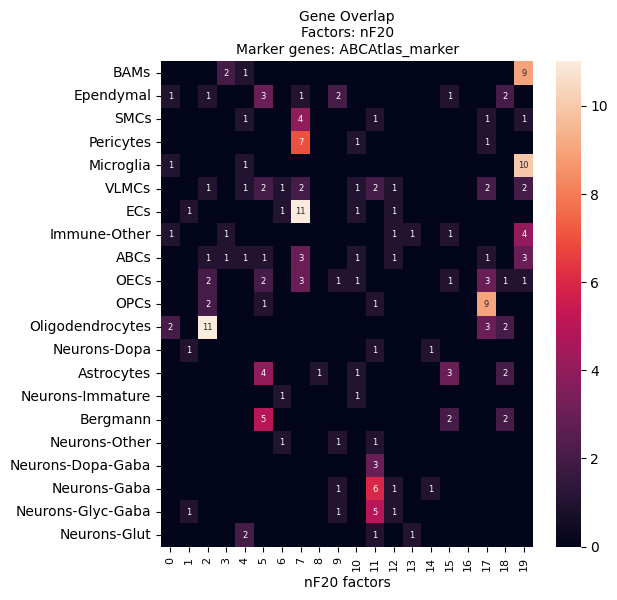

In [28]:
pl = ficture_plot.plot_overlap_heatmap(
    ficture_DEGs=ficture_DEGs,
    marker_dict=ABCAtlas_marker,
    factor_i=factor_i,
    marker_name=marker_dicts["ABCAtlas_marker"],
)

## Transcript count

In [29]:
pl = ficture_plot.plot_factors(
    sdata, name=sample_name, factor_i=factor_i, factor_no=factor_no
)
output_path = os.path.join(
    base_dir, f"{date.today().strftime('%Y%m%d')}_transcript_counts_{factor_i}.png"
)
pl.savefig(output_path, dpi=300, bbox_inches="tight")
plt.close()

In [30]:
factor_no

20

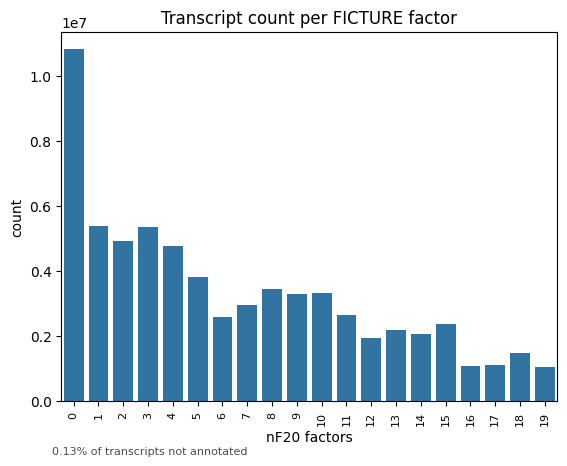

In [31]:
pl

## PCA + UMAP

In [25]:
# Calculate gene x factor count matrix
gene_factor_count = (
    sdata[f"{sample_name}_all_transcript_factors"]
    .groupby(["gene", f"{factor_i}_factors"])
    .count()
    .compute()
)
factor_by_gene_count_df = gene_factor_count["x"].unstack()

# Sort factors by ascending factor indices
factor_by_gene_count_df = factor_by_gene_count_df.loc[
    :, factor_by_gene_count_df.columns.astype(int).sort_values()
]

# Drop last factor (containing uncategorized transcripts)
factor_by_gene_count_df = factor_by_gene_count_df.iloc[:, :-1]

# Normalize factor-by-gene count matrix by factor size
# Caution: size is calculated on z=3, but transcripts are from all z planes
factor_size = (
    sdata[f"{sample_name}_{factor_i}_pixel_factors"]
    .groupby("K1")
    .count()
    .compute()["x"]
)
# Reindex factor_size to align with the index of factor_by_gene_count_df
factor_size_aligned = factor_size.reindex(factor_by_gene_count_df.columns)
norm_factor_by_gene_count_df = factor_by_gene_count_df / factor_size_aligned

/dss/dsshome1/0C/ra98gaq/miniconda3/envs/sdata/lib/python3.11/site-packages/dask/dataframe/groupby.py:1445: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(


In [26]:
print(factor_by_gene_count_df.T.index)
print(factor_size_aligned.index)

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype='int64', name='nF20_factors')
Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype='int64', name='nF20_factors')


In [27]:
factor_size.shape

(20,)

In [28]:
factor_by_gene_count_df.shape

(550, 20)

In [29]:
norm_factor_by_gene_count_df.shape

(550, 20)

In [30]:
if factor_i not in ["nF28"]:
    assert len(factor_by_gene_count_df.T) == factor_no

In [31]:
factor_by_gene_count_df.T.iloc[0:3, 0:10]

gene,A830036E02Rik,AI593442,Abca1,Abcb1a,Abcb1b,Abcc9,Abcg2,Acan,Ace2,Acer2
nF20_factors,,,,,,,,,,
0,127,2720,489,451,35,71,351,31,14,4298
1,10502,11011,3274,385,1936,45,1341,1113,490,683
2,182,2128,18060,807,133,86,209,483,399,3530


In [32]:
norm_factor_by_gene_count_df.T.iloc[0:3, 0:10]

gene,A830036E02Rik,AI593442,Abca1,Abcb1a,Abcb1b,Abcc9,Abcg2,Acan,Ace2,Acer2
nF20_factors,,,,,,,,,,
0,0.000008,0.000180,0.000032,0.000030,0.000002,0.000005,0.000023,0.000002,9.250496e-07,0.000284
1,0.001440,0.001510,0.000449,0.000053,0.000266,0.000006,0.000184,0.000153,6.720448e-05,0.000094
2,0.000026,0.000308,0.002617,0.000117,0.000019,0.000012,0.000030,0.000070,5.782186e-05,0.000512


In [33]:
import anndata as ad
from scipy.sparse import csr_matrix

In [34]:
# create anndata object
counts = csr_matrix(factor_by_gene_count_df.T, dtype=np.float32)
norm = csr_matrix(norm_factor_by_gene_count_df.T, dtype=np.float32)
adata = ad.AnnData(counts)
adata.layers["counts"] = adata.X
adata.var = pd.DataFrame(index=factor_by_gene_count_df.T.columns.astype(str))
adata.obs = pd.DataFrame(index=factor_by_gene_count_df.T.index.astype(str))
adata.layers["norm"] = norm
# scale genes to unit variance and zero mean
adata.layers["zscore"] = sc.pp.scale(
    adata.layers["norm"], zero_center=True, max_value=None
)
# equals scipy.stats.zscore(dense_data, axis=0) # column-wise = gene-wise

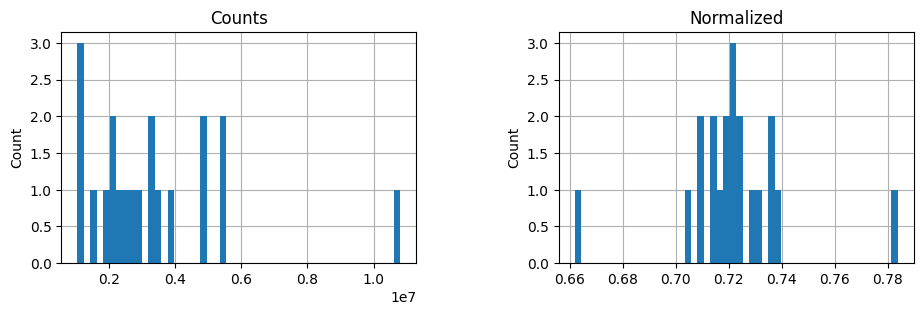

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(11, 3), gridspec_kw={"wspace": 0.4})
for ax, data, title in zip(
    axs,
    [adata.layers["counts"].sum(1), adata.layers["norm"].sum(1)],
    ["Counts", "Normalized"],
):
    sns.histplot(data, kde=False, bins=50, ax=ax, zorder=2, alpha=1)
    ax.set_title(title)
    ax.grid(True)
    ax.get_legend().remove() if ax.get_legend() else None
    for patch in ax.patches:
        patch.set_edgecolor("none")
plt.show()

In [36]:
# process
adata.X = adata.layers["norm"]
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/dss/dsshome1/0C/ra98gaq/miniconda3/envs/sdata/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


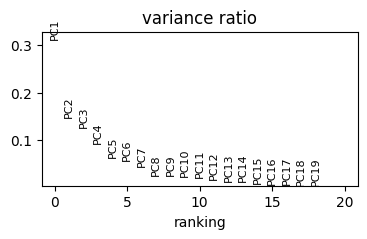

In [37]:
with plt.rc_context({"figure.figsize": (4, 2)}):
    sc.pl.pca_variance_ratio(adata, n_pcs=len(adata.obs.index))

In [38]:
# get color code for factors
factor_color_code = ficture_DEGs["RGB"]
colors = [
    [float(c) / 255 for c in factor_color_code[factor].split(",")]
    for factor in adata.obs.index.astype(int)
]
# map the colors to categorical index values
adata.obs["index1"] = adata.obs.index.astype(int).astype("category")
color_dict = {
    cat: colors[i] for i, cat in enumerate(adata.obs["index1"].cat.categories)
}

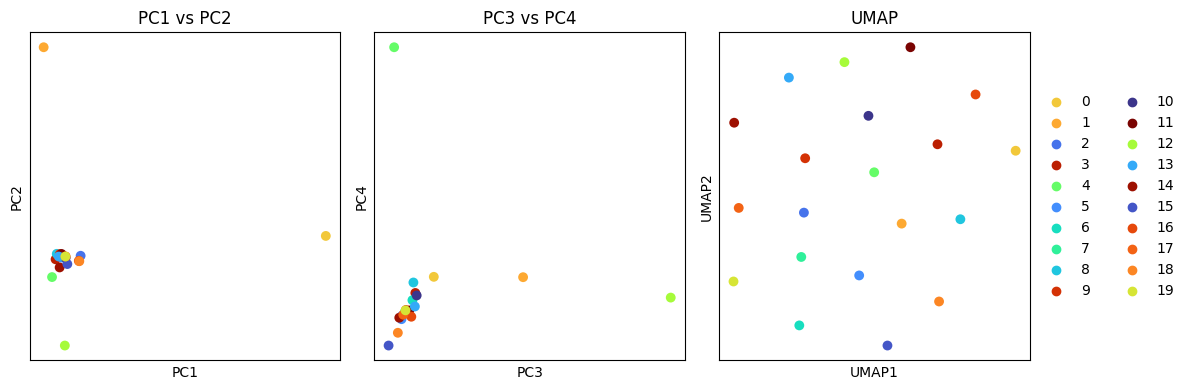

In [39]:
pt_size = 2e2
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
sc.pl.pca(
    adata,
    components=["1,2"],
    size=pt_size,
    color="index1",
    palette=color_dict,
    title="PC1 vs PC2",
    ax=axs[0],
    show=False,
)
axs[0].legend().set_visible(False)
sc.pl.pca(
    adata,
    components=["3,4"],
    size=pt_size,
    color="index1",
    palette=color_dict,
    title="PC3 vs PC4",
    ax=axs[1],
    show=False,
)
axs[1].legend().set_visible(False)
sc.pl.umap(
    adata,
    size=pt_size,
    color="index1",
    palette=color_dict,
    title="UMAP",
    ax=axs[2],
    show=False,
)
plt.tight_layout()
output_path = os.path.join(
    base_dir, f"{date.today().strftime('%Y%m%d')}_PCA_UMAP_{factor_i}.png"
)
plt.savefig(output_path, dpi=300)
plt.show()

## Marker gene score

In [41]:
factor_i

'nF20'

In [54]:
# heatmap
# loop through all marker dictionaries
for marker_name in marker_dicts:
    pl = ficture_plot.plot_clustermap_with_marker_genes(
        adata, marker_dicts[marker_name], marker_name=marker_name, factor_i=factor_i
    )
    output_path = os.path.join(
        base_dir,
        f"{date.today().strftime('%Y%m%d')}_marker_gene_scores_heatmap_{factor_i}_with_{marker_name}.png",
    )
    pl.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.close()

/dss/dsshome1/0C/ra98gaq/miniconda3/envs/sdata/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:169: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/dss/dsshome1/0C/ra98gaq/miniconda3/envs/sdata/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:169: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/dss/dsshome1/0C/ra98gaq/miniconda3/envs/sdata/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:169: PerformanceWarning: DataFrame is highly fr

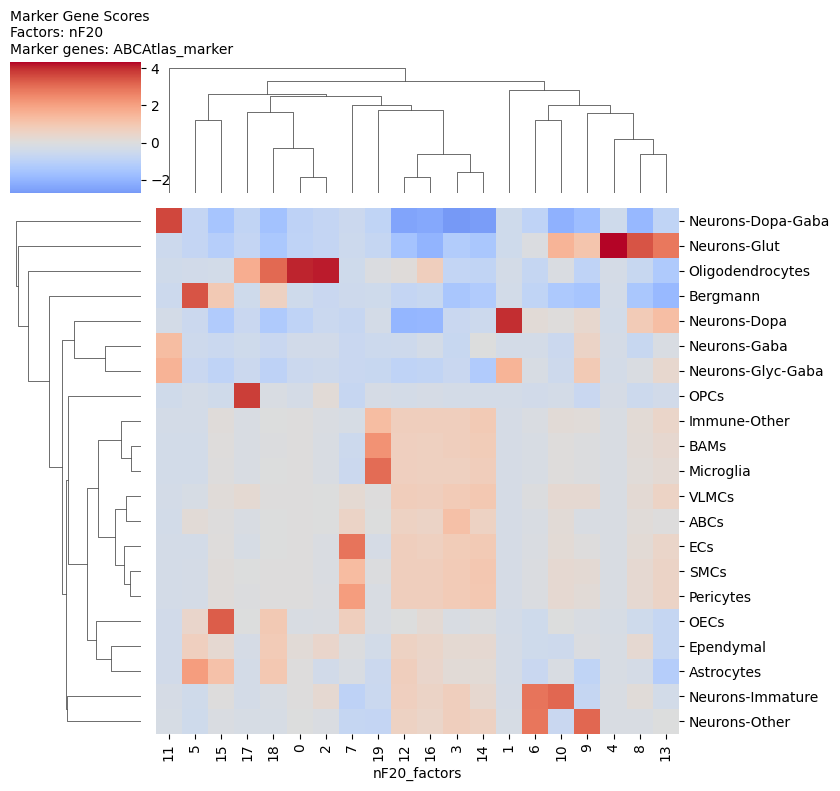

In [42]:
pl = ficture_plot.plot_clustermap_with_marker_genes(
    adata,
    ABCAtlas_marker,
    factor_i=factor_i,
    marker_name=marker_dicts["ABCAtlas_marker"],
)

In [56]:
# pca + umap: loop through samples
for dimred, plot_func in [("pca", sc.pl.pca), ("umap", sc.pl.umap)]:
    for marker_name in marker_dicts:
        adatatemp = adata.copy()
        adatatemp.obs = pd.DataFrame(index=adatatemp.obs.index)
        adatatemp, marker_genes_in_data = ficture_plot.sort_and_score(
            adatatemp, marker_dicts[marker_name]
        )

        with plt.rc_context({"figure.figsize": (6, 6)}):
            plot_func(
                adatatemp,
                color=marker_genes_in_data.keys(),
                frameon=False,
                ncols=3,
                cmap="RdYlBu_r",
                size=pt_size,
                sort_order=True,
                show=False,
            )

        plt.savefig(
            os.path.join(
                base_dir,
                f"{date.today().strftime('%Y%m%d')}_marker_gene_scores_{dimred.upper()}_{factor_i}_with_{marker_name}.png",
            ),
            dpi=300,
            bbox_inches="tight",
        )
        plt.close()

## Most abundant genes for each factor
* absolute counts (hint that factor might be specific to one gene only)

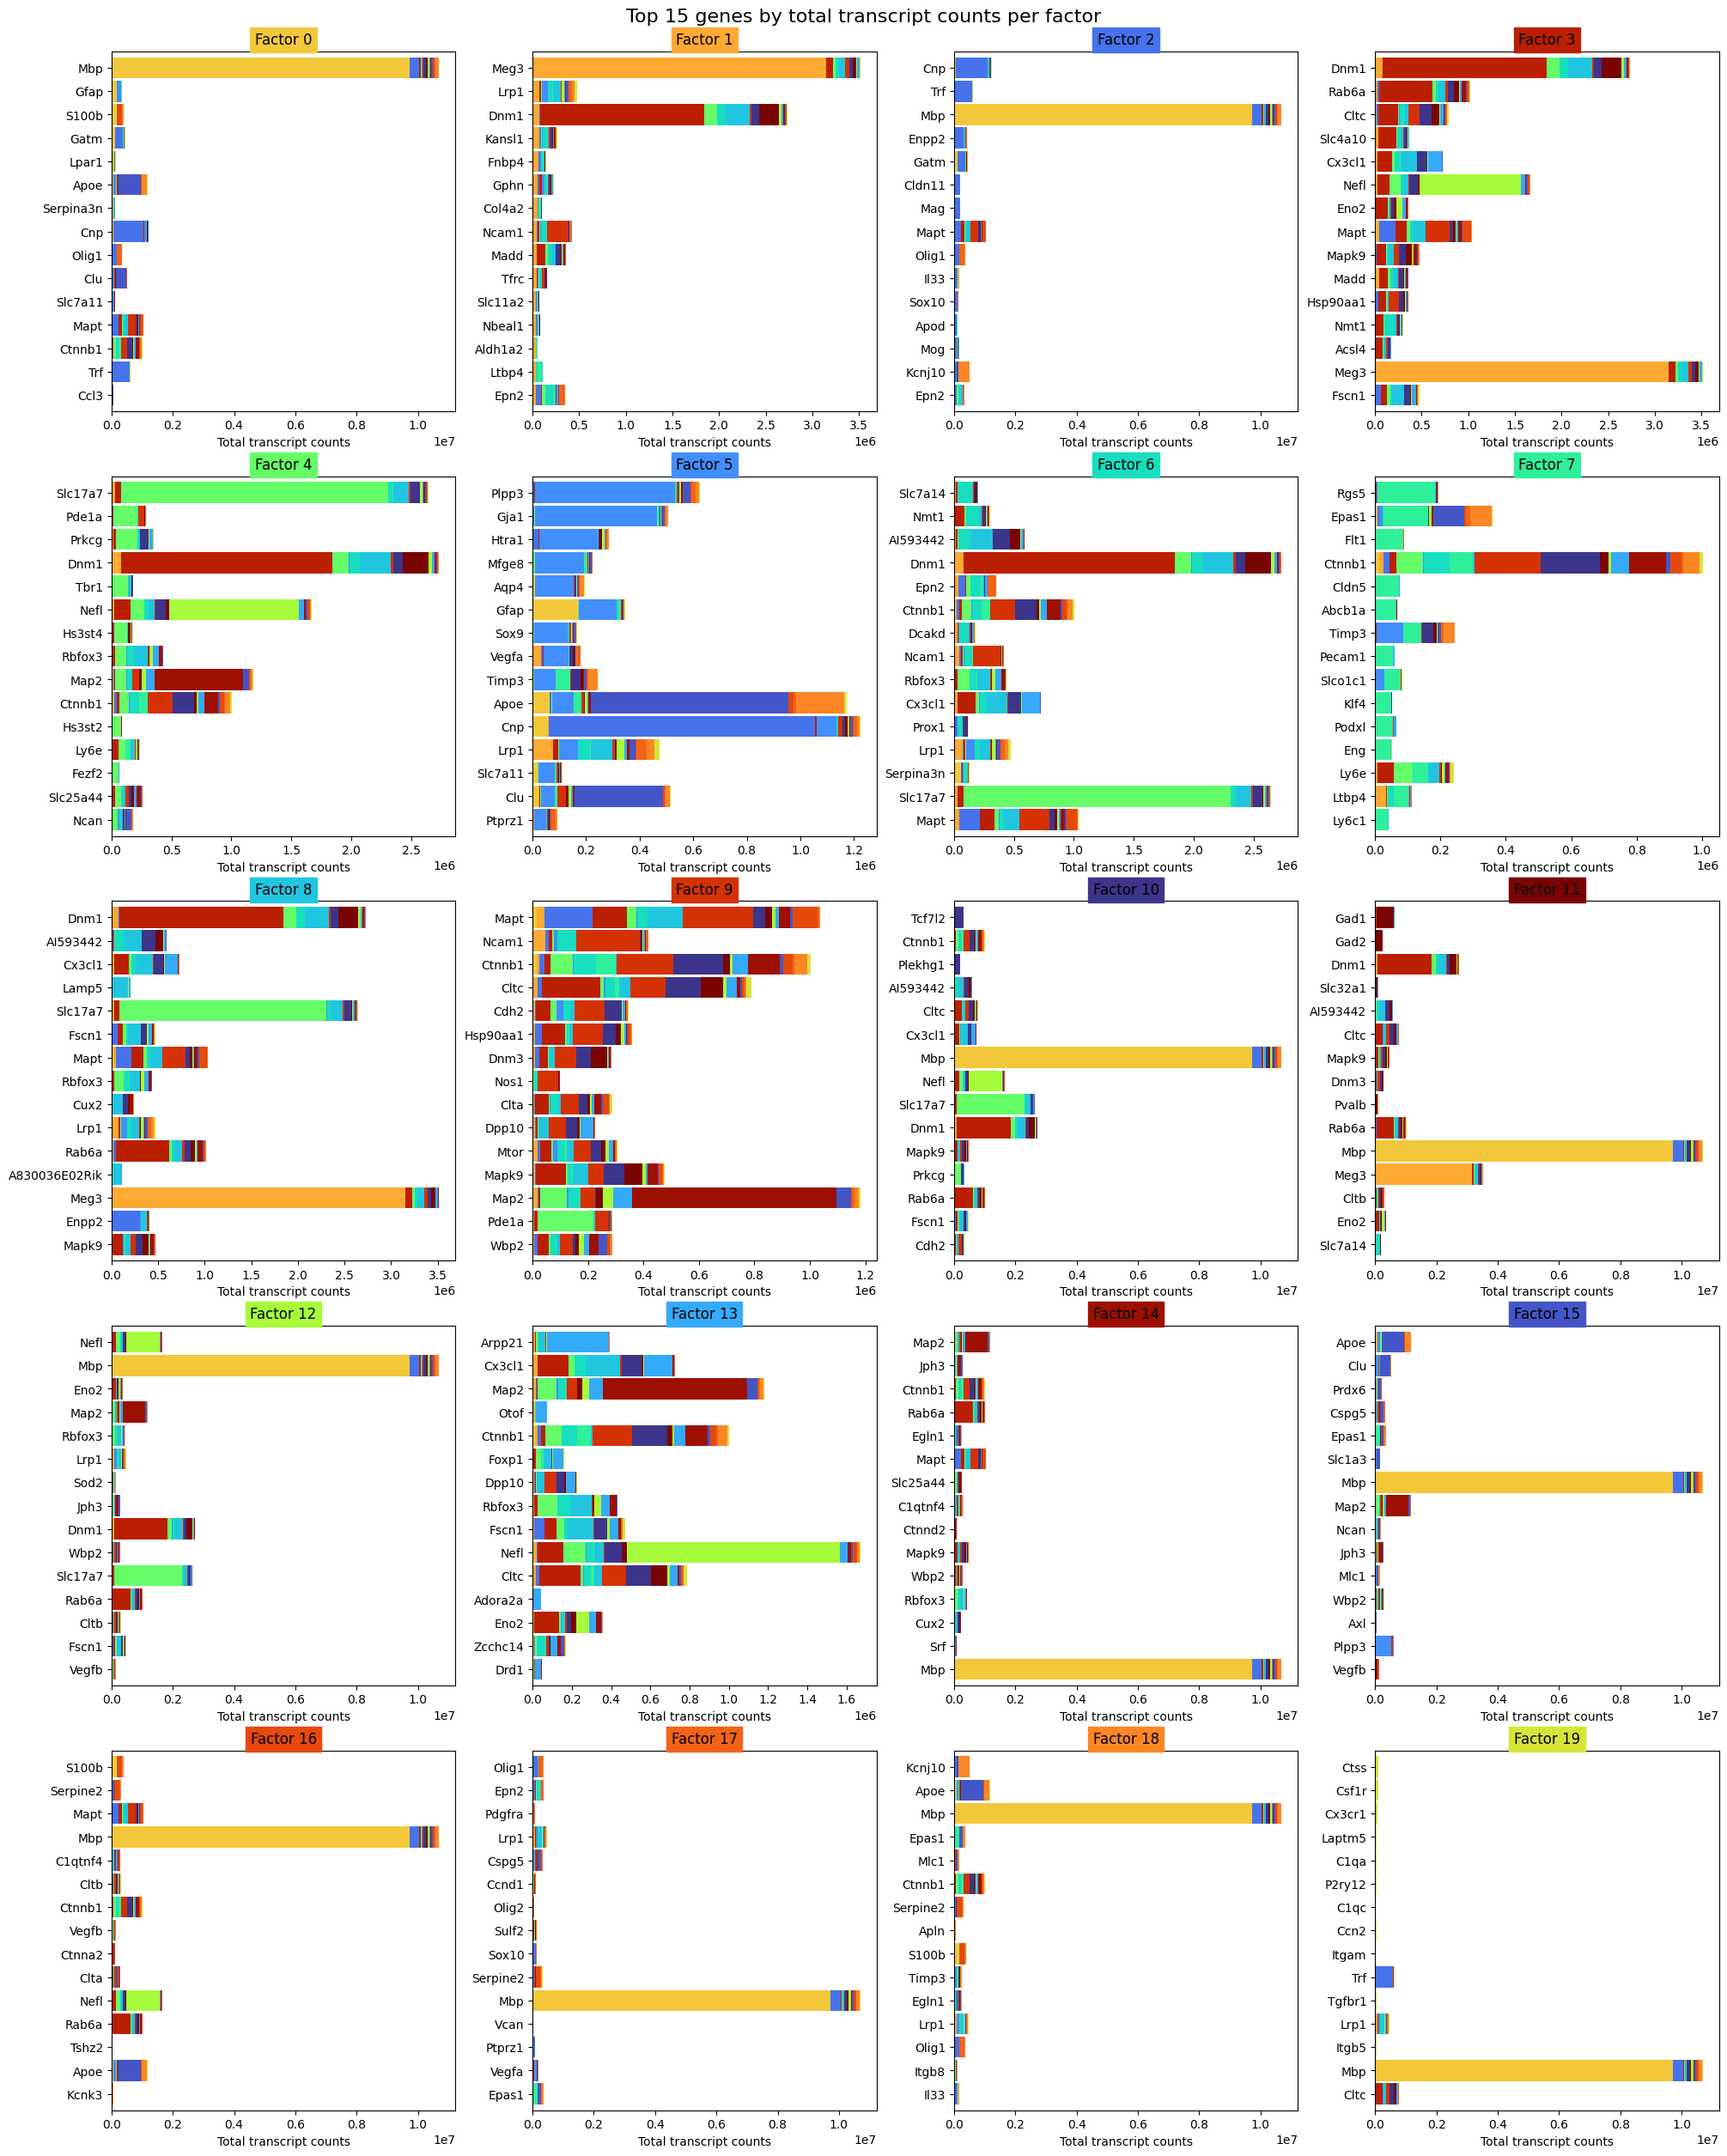

In [57]:
n_rows = -(-len(adata.obs.index) // 4)
fig, axes = plt.subplots(n_rows, 4, figsize=(20, 5 * n_rows), constrained_layout=True)
axes = axes.flatten()
for factor, ax in zip(adata.obs.index.astype(int), axes):
    factor_by_gene_count_df.loc[
        factor_by_gene_count_df[factor].nlargest(15).index
    ].plot(kind="barh", stacked=True, ax=ax, legend=False, color=colors, width=0.9)
    ax.invert_yaxis()
    ax.set_ylabel("")
    ax.set_xlabel("Total transcript counts")
    ax.set_title(f"Factor {factor}", backgroundcolor=color_dict[factor])

for ax in axes[len(adata.obs.index) :]:
    ax.set_visible(False)
plt.suptitle("Top 15 genes by total transcript counts per factor", fontsize=16)
plt.savefig(
    os.path.join(
        base_dir,
        f"{date.today().strftime('%Y%m%d')}_abundant_genes_per_factor_{factor_i}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)
# plt.show()

## Calculate DE genes

Redundant, as already done by FICTURE (see above)  
Also, scanpy.tl.rank_genes_groups doesn't work with groups containing only a single value

## Highly expressed genes overall
using transcripts only

In [58]:
gene_count = (
    sdata[f"{sample_name}_all_transcript_factors"]
    .groupby("gene")
    .count()["x"]
    .compute()
)

/dss/dsshome1/0C/ra98gaq/miniconda3/envs/sdata/lib/python3.11/site-packages/dask/dataframe/groupby.py:1445: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(


In [59]:
pd.Series(zscore(gene_count), gene_count.index).sort_values(ascending=False).head(20)

gene
Mbp         20.020895
Meg3         6.422838
Dnm1         4.946575
Slc17a7      4.787223
Nefl         2.936109
Cnp          2.086999
Map2         2.013730
Apoe         2.002197
Mapt         1.736132
Rab6a        1.701284
Ctnnb1       1.669540
Cltc         1.263038
Cx3cl1       1.145624
Gad1         0.969538
Trf          0.956225
Plpp3        0.952695
AI593442     0.890806
Clu          0.752819
Kcnj10       0.738120
Gja1         0.728383
dtype: float64

# Annotate

* combining results from multiple approaches (see other script) to assign factors to cell types
* set up for MERFISH sample foxf2_s2_r1

In [15]:
ficture_output = os.listdir(
    os.path.join(data_dir, "samples", sample_name, "results", "Ficture", "output")
)
ficture_output
# nF21.d_6 based on pseudobulk RNA-seq input (excl MBP)
# nF28.d_6 based on pseudobulk RNA-seq input (excl MBP and incl vascular zonation subtypes)

['nF50.d_6',
 'nF28.d_6-bulkRNAseq-inclzonation',
 'nF10.d_6',
 'nF30.d_6',
 'nF5.d_6',
 'nF25.d_6',
 'nF21.d_6-bulkRNAseq-exclMBP',
 'nF20.d_6']

In [16]:
all_factors = [f.split(".d_6")[0] for f in ficture_output]
all_factors

['nF50', 'nF28', 'nF10', 'nF30', 'nF5', 'nF25', 'nF21', 'nF20']

In [17]:
# Create empty csv of all factor combinations
data = []
for method in [int(f.split("nF")[1]) for f in all_factors]:
    for factor in range(0, method + 1):
        data.append(
            {
                "factor_method": f"nF{method}",
                "factor": factor,
                "cell_type": "",  # to be annotated
                "confidence": "",  # to be annotated, low-medium-high based on concordance of different methods
                "input_cell_type": "NA",  # when using bulkRNA-seq reference as input
            }
        )

df = pd.DataFrame(data)
output_path = os.path.join(
    base_dir, "..", date.today().strftime("%Y%m%d") + "_factor_annotations.csv"
)
if not os.path.exists(output_path):
    df.to_csv(output_path, index=False)

df.head(3)

,factor_method,factor,cell_type,confidence,input_cell_type
0,nF50,0,,,NA
1,nF50,1,,,NA
2,nF50,2,,,NA


In [18]:
# Annotate csv manually based on exported images

In [9]:
tdate = "20250212"
output_path = os.path.join(base_dir, "..", tdate + "_factor_annotations.csv")
factor_annotations = pd.read_csv(output_path)
factor_annotations.head()

,factor_method,factor,cell_type,confidence,input_cell_type
0,nF50,0,Neurons,medium,NaN
1,nF50,1,Oligodendrocytes,high,NaN
2,nF50,2,Neurons-Glut,high,NaN
3,nF50,3,ECs-Pericytes,high,NaN
4,nF50,4,Astrocytes,high,NaN


In [10]:
factor_annotations.groupby("factor_method")["confidence"].value_counts()

factor_method  confidence
nF10           high           7
               medium         4
nF20           high          13
               low            5
               medium         3
nF21           high          16
               medium         6
nF25           high           9
               medium         9
               low            8
nF28           medium        16
               high          10
               low            1
nF30           high          12
               low           10
               medium         9
nF5            high           6
nF50           medium        20
               low           19
               high          12
Name: count, dtype: int64

In [11]:
factor_annotations.groupby("factor_method")["confidence"].value_counts(
    normalize=True
).mul(100).round(1)

factor_method  confidence
nF10           high           63.6
               medium         36.4
nF20           high           61.9
               low            23.8
               medium         14.3
nF21           high           72.7
               medium         27.3
nF25           high           34.6
               medium         34.6
               low            30.8
nF28           medium         59.3
               high           37.0
               low             3.7
nF30           high           38.7
               low            32.3
               medium         29.0
nF5            high          100.0
nF50           medium         39.2
               low            37.3
               high           23.5
Name: proportion, dtype: float64

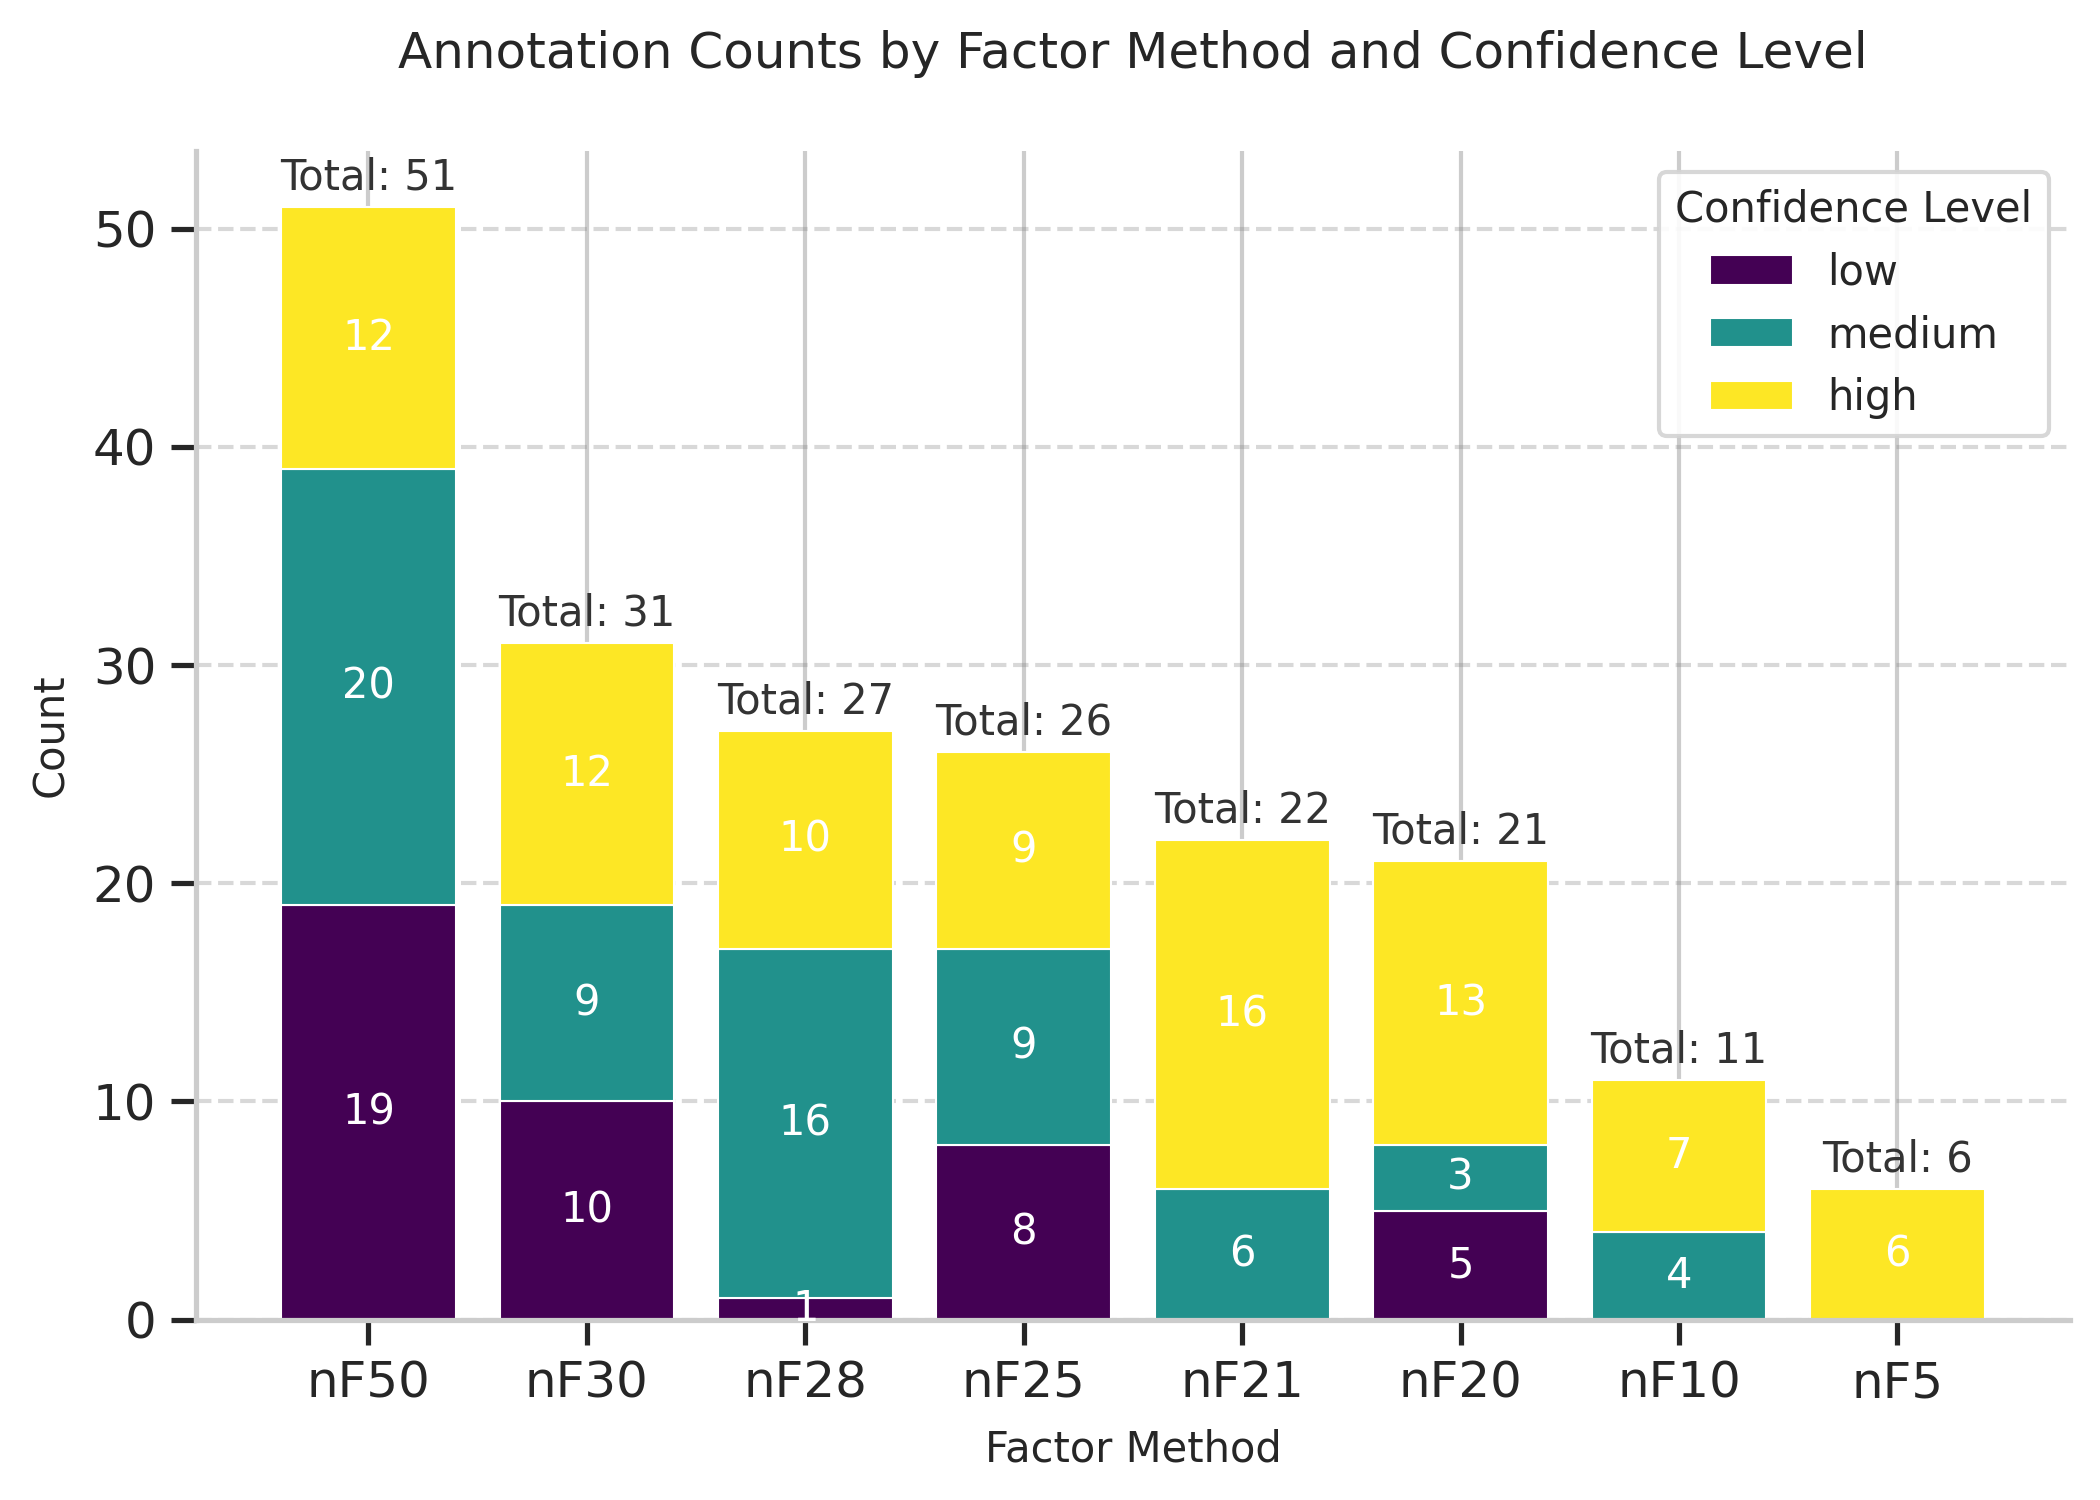

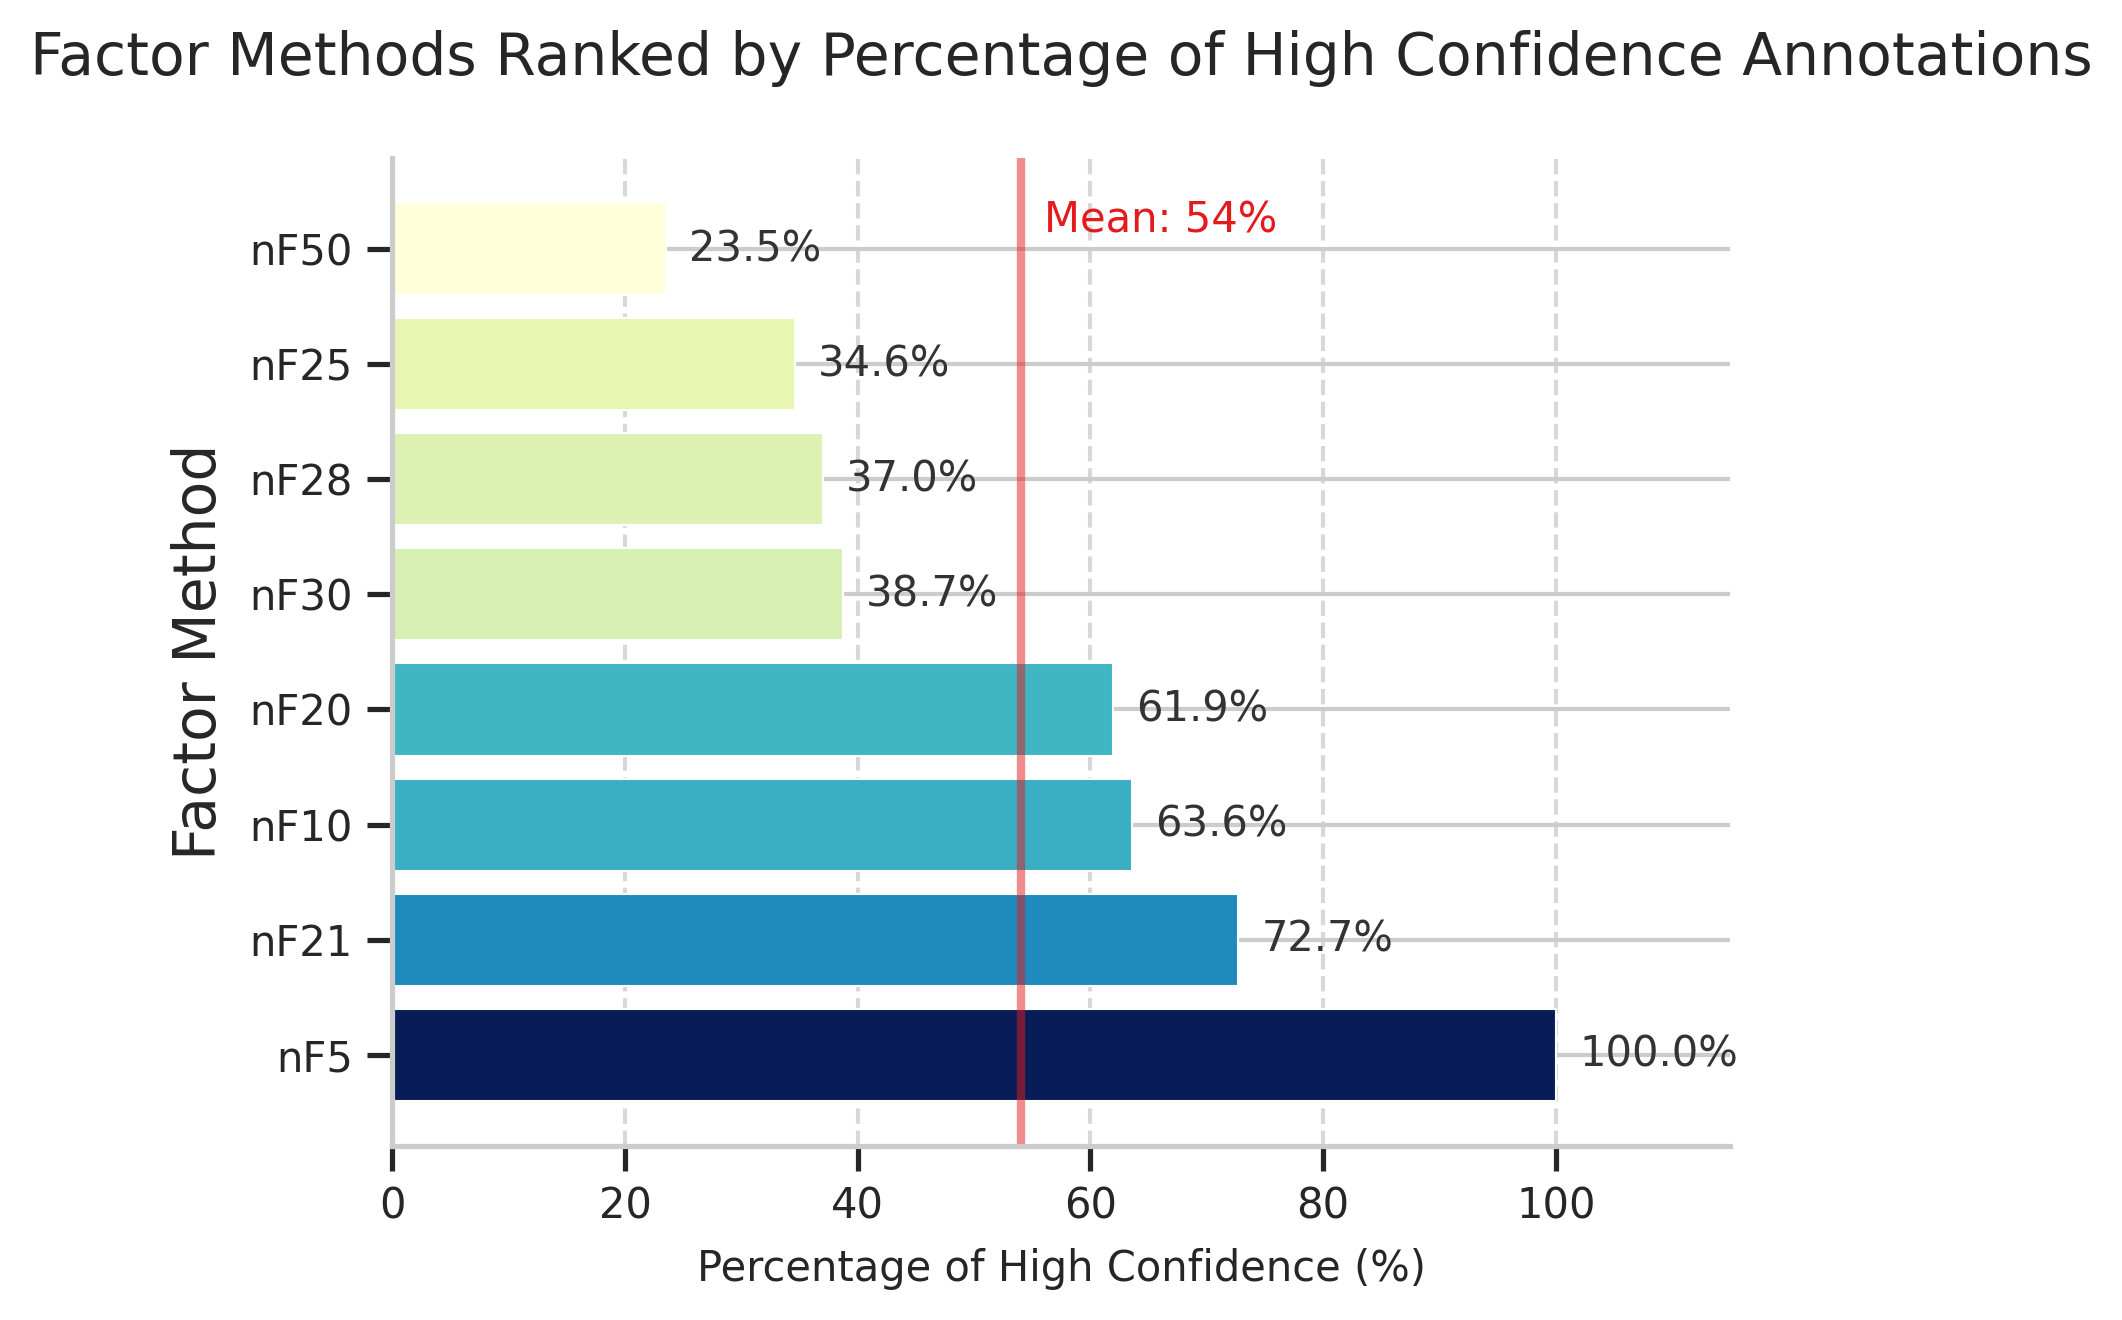

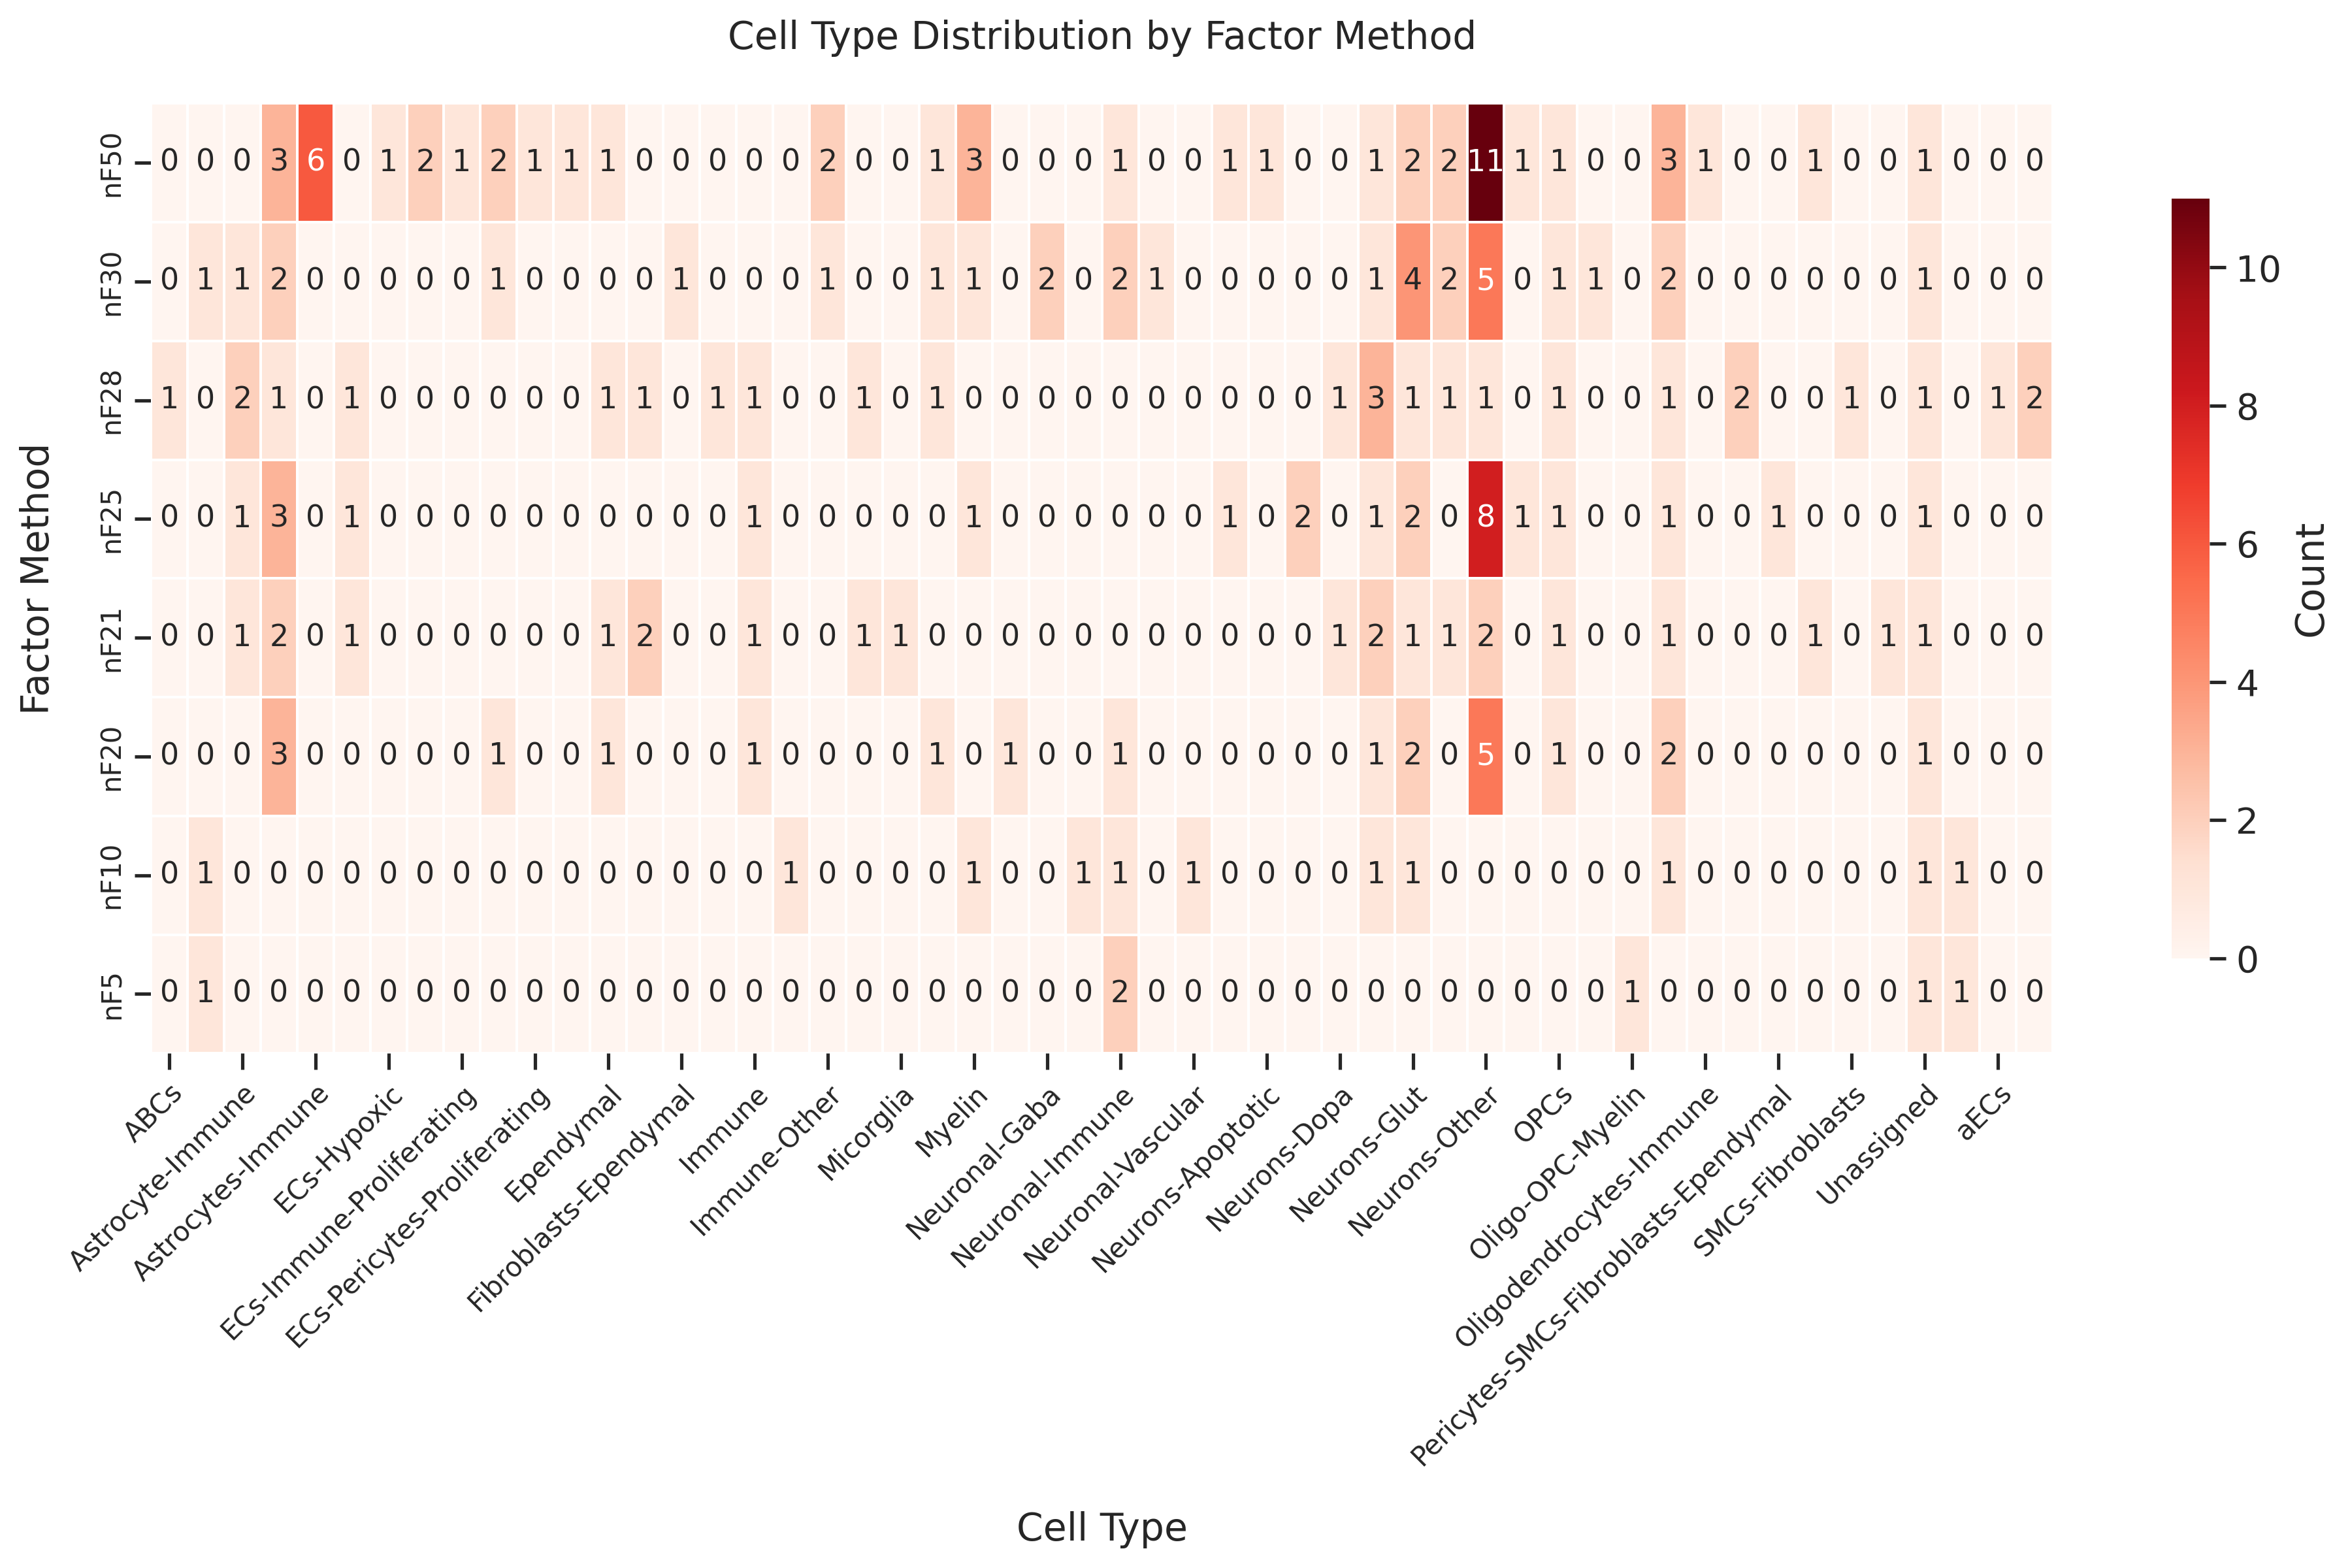

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style and colors
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
confidence_colors = {"low": "#440154", "medium": "#21918c", "high": "#fde725"}
cell_cmap = sns.color_palette("Reds", as_cmap=True)

# Process the data
counts = factor_annotations.groupby("factor_method")["confidence"].value_counts()
counts_df = counts.reset_index(name='count')
pct = factor_annotations.groupby("factor_method")["confidence"].value_counts(normalize=True).mul(100).round(1)
pct_df = pct.reset_index(name='percentage')

# Pivot data and sort by total count
counts_pivot = counts_df.pivot(index='factor_method', columns='confidence', values='count').fillna(0)
# Ensure consistent confidence order (low, medium, high)
ordered_levels = [level for level in ['low', 'medium', 'high'] if level in counts_pivot.columns]
counts_pivot = counts_pivot[ordered_levels]
counts_pivot['total'] = counts_pivot.sum(axis=1)
counts_pivot = counts_pivot.sort_values('total', ascending=False)

# Get sorted factor methods and confidence levels
factor_methods = counts_pivot.index.tolist()
confidence_levels = ordered_levels

# ------------- Figure 1: Counts Bar Chart -------------
fig, ax1 = plt.subplots(figsize=(8, 6), dpi=300)
fig.patch.set_facecolor('white')
ax1.set_facecolor('#ffffff')

bottom = np.zeros(len(factor_methods))
for level in confidence_levels:
    if level in counts_pivot.columns:
        values = counts_pivot[level].values
        ax1.bar(factor_methods, values, bottom=bottom, label=level, 
                color=confidence_colors.get(level), edgecolor='white', linewidth=0.5)
        
        # Add count labels
        for i, v in enumerate(values):
            if v > 0:
                ax1.text(i, bottom[i] + v/2, f'{int(v)}', ha='center', va='center', 
                         fontweight='normal', color='white', fontsize=10)
        bottom += values

# Add total counts on top
for i, total in enumerate(counts_pivot['total']):
    ax1.text(i, total + 0.8, f'Total: {int(total)}', ha='center', 
             fontweight='normal', fontsize=10, color='#333333')

# Style enhancements
ax1.set_title('Annotation Counts by Factor Method and Confidence Level', 
              fontsize=12, pad=20, fontweight='medium')
ax1.set_ylabel('Count', fontsize=10, fontweight='medium', labelpad=5)
ax1.set_xlabel('Factor Method', fontsize=10, fontweight='medium', labelpad=5)
ax1.grid(axis='y', linestyle='--', alpha=0.3, color='gray')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis='both', which='major', labelsize=12)

# Place legend in top left corner
legend = ax1.legend(title='Confidence Level', title_fontsize=10, fontsize=10, 
                    loc='upper right', frameon=True, framealpha=0.9, edgecolor='lightgray')
legend.get_frame().set_facecolor('#ffffff')

plt.tight_layout(pad=3.0)

# ------------- Figure 2: High Confidence Ranking -------------
pct_pivot = pct_df.pivot(index='factor_method', columns='confidence', values='percentage').fillna(0)
pct_pivot = pct_pivot.reindex(factor_methods)  # Use same order as count chart

if 'high' in pct_pivot.columns:
    fig2, ax3 = plt.subplots(figsize=(6, 5), dpi=300)
    fig2.patch.set_facecolor('white')
    ax3.set_facecolor('#ffffff')
    
    high_confidence_pct = pct_pivot['high'].sort_values(ascending=False)
    
    # Use color gradient for bars
    norm = plt.Normalize(high_confidence_pct.min(), high_confidence_pct.max())
    colors = plt.cm.YlGnBu(norm(high_confidence_pct.values))
    
    bars = ax3.barh(high_confidence_pct.index, high_confidence_pct.values, 
                    color=colors, height=0.8, edgecolor='white', linewidth=0.5)

    # Add percentage labels
    for i, value in enumerate(high_confidence_pct.values):
        ax3.text(value + 2, i, f"{value:.1f}%", va='center', fontsize=10, 
                fontweight='medium', color='#333333')

    # Add mean line
    avg_high = high_confidence_pct.mean()
    ax3.axvline(avg_high, color='#e41a1c', linestyle='-', linewidth=2, alpha=0.5)
    ax3.text(avg_high + 2, len(high_confidence_pct) - 0.75, f"Mean: {avg_high:.0f}%", 
             color='#e41a1c', fontsize=10, fontweight='normal', va='center')

    # Style enhancements
    ax3.set_title('Factor Methods Ranked by Percentage of High Confidence Annotations', 
                  fontsize=14, pad=20, fontweight='normal')
    ax3.set_xlabel('Percentage of High Confidence (%)', fontsize=10, fontweight='medium', labelpad=5)
    ax3.set_ylabel('Factor Method', fontsize=14, fontweight='medium', labelpad=5)
    ax3.grid(axis='x', linestyle='--', alpha=0.3, color='gray')
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.tick_params(axis='both', which='major', labelsize=10)
    ax3.set_xlim(0, high_confidence_pct.max() * 1.15)
    
    plt.tight_layout(pad=2.0)

# ------------- Figure 3: Cell Type Distribution -------------
if 'cell_type' in factor_annotations.columns:
    # Process cell type data
    cell_counts = factor_annotations.groupby(['factor_method', 'cell_type']).size().reset_index(name='count')
    cell_pivot = cell_counts.pivot(index='factor_method', columns='cell_type', values='count').fillna(0)
    cell_pivot = cell_pivot.reindex(factor_methods)  # Use same order as count chart
    
    fig3, ax4 = plt.subplots(figsize=(14, 9), dpi=300)
    fig3.patch.set_facecolor('white')
    ax4.set_facecolor('#ffffff')
    
    # Create heatmap
    sns.heatmap(cell_pivot, annot=True, fmt='g', cmap=cell_cmap, 
                linewidths=0.5, linecolor='white', ax=ax4,
                cbar_kws={'label': 'Count', 'shrink': 0.8},
                annot_kws={"size": 11, "weight": "medium"})
    
    # Style enhancements
    ax4.set_title('Cell Type Distribution by Factor Method', fontsize=14, pad=20, fontweight='normal')
    ax4.set_ylabel('Factor Method', fontsize=14, fontweight='medium', labelpad=15)
    ax4.set_xlabel('Cell Type', fontsize=14, fontweight='medium', labelpad=15)
    ax4.tick_params(axis='both', which='major', labelsize=10)
    
    # Rotate x-labels if needed
    if cell_pivot.shape[1] > 5:
        plt.setp(ax4.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    
    plt.tight_layout(pad=3.0)

plt.show()